https://www.kaggle.com/c/journey-springfield  
Kaggle Team: **Valentin_Aliferov_313008459**  
Kaggle Score: **0.99681**  

In [ ]:
!pip install -q --upgrade gdown efficientnet-pytorch

In [1]:
import gc
import os
import gdown
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet

In [3]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# torch.set_deterministic(True)
# torch.use_deterministic_algorithms(True)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%%bash
gdown https://drive.google.com/uc?id=1IfJFFzolwFVYXm0Ktvk_iUqurMHzGIAK -q -O simpsons.zip
unzip -q simpsons.zip
rm -f simpsons.zip

In [5]:
def tensor_to_image(x):
    x = x.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return np.clip(std * x + mean, 0, 1)

def image_to_tensor(x):
    w, h = x.size
    max_wh = np.max([w, h])
    hp = int((max_wh - w) / 2)
    vp = int((max_wh - h) / 2)
    pad = (hp, vp, hp, vp)
    x = F.pad(x, pad, 0, 'constant')
    x = x.resize((224, 224))
    x = np.array(x, dtype='float32') / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    transform = transforms.Compose([ 
        transforms.ToTensor(), 
        # transforms.RandomHorizontalFlip(), 
        transforms.Normalize(mean, std)])
    return transform(x)

In [6]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files, mode, labels=None):
        super().__init__()
        self.labels = labels
        self.files = files
        self.mode = mode

    def __getitem__(self, index):
        x = Image.open(self.files[index])
        x.load()
        x = image_to_tensor(x)
        if self.mode == 'test': return x
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.files)

In [7]:
test_files = sorted(list(Path('simpsons/test').rglob('*.jpg')))
train_val_files = sorted(list(Path('simpsons/train').rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
labels = sorted(np.unique(np.array(train_val_labels)))
with open('labels.txt','w') as f: f.write('\n'.join(labels))
label_dict_li = {l:i for i, l in enumerate(labels)}
label_dict_il = {i:l for i, l in enumerate(labels)}

split_result = train_test_split(train_val_files, train_val_labels, test_size=0.25, stratify=train_val_labels)
train_files, val_files, train_labels, val_labels = split_result

val_label_ids = [label_dict_li[label] for label in val_labels]
train_label_ids = [label_dict_li[label] for label in train_labels]
val_dataset = SimpsonsDataset(val_files, mode='val', labels=val_label_ids)
train_dataset = SimpsonsDataset(train_files, mode='train', labels=train_label_ids)
test_dataset = SimpsonsDataset(test_files, mode='test')

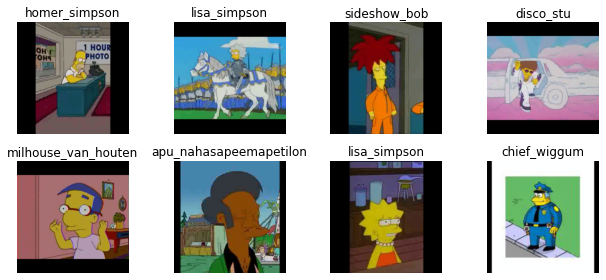

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(9,4))
for ax in axes.flat:
    i = int(np.random.uniform(0, 1000))
    x, y = val_dataset[i]
    ax.imshow(tensor_to_image(x))
    ax.set_title(labels[y])
    ax.axis('off')
plt.tight_layout()

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    
    model.train()
    running_loss = 0.0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss

In [10]:
def eval_epoch(model, val_loader, criterion):

    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
    
    val_loss = running_loss / processed_size
    return val_loss

In [11]:
def train(model, train_dataset, val_dataset, epochs, batch_size):
    
    history = []
    gc.collect()
    torch.cuda.empty_cache()
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_loader, criterion, opt)
        val_loss = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, val_loss))
        print((f'epoch: {epoch+1} / {epochs}, '
               f'train_loss: {train_loss:.4f}, '
               f'val_loss: {val_loss:.4f}'))

    train_loss, val_loss = zip(*history)
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [12]:
def predict_one(model, x):
    model.eval()
    X = x.unsqueeze(0)
    Y = model(X.to(device)).detach().cpu()
    return Y[0].numpy()

In [13]:
def predict_set(model, dataset, batch_size):
    Ys = []
    model.eval()
    for batch in DataLoader(dataset, batch_size, shuffle=False):
        X = batch[0] if type(batch) is list else batch
        Y = model(X.to(device)).detach().cpu()
        Ys.append(Y)
    return torch.cat(Ys).numpy()

In [14]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(labels)) # from_name
# for param in model.parameters(): param.requires_grad = False
# for param in model._fc.parameters(): param.requires_grad = True
model._fc = nn.Linear(model._fc.in_features, len(labels))
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


epoch: 1 / 5, train_loss: 0.3706, val_loss: 0.2375
epoch: 2 / 5, train_loss: 0.1762, val_loss: 0.1727
epoch: 3 / 5, train_loss: 0.0967, val_loss: 0.1390
epoch: 4 / 5, train_loss: 0.0561, val_loss: 0.1235
epoch: 5 / 5, train_loss: 0.0352, val_loss: 0.1191


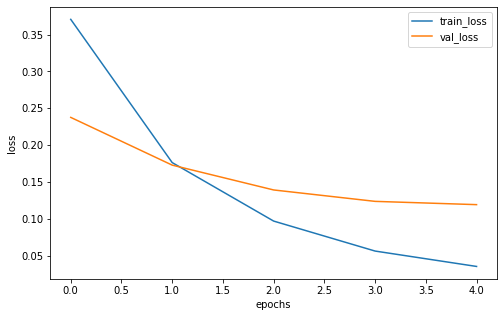

In [16]:
train(model, train_dataset, val_dataset, epochs=5, batch_size=64)

In [17]:
torch.save(model.state_dict(), 'efficientnet-b0.pt')

In [18]:
index = 0
x = val_dataset[index][0]
y_prob = predict_one(model, x)
y_pred = np.argmax(y_prob)
y_true = val_dataset[index][1]
print(f'y_pred[{index}]: {labels[y_pred]}')
print(f'y_true[{index}]: {labels[y_true]}')

y_pred[0]: marge_simpson
y_true[0]: marge_simpson


In [19]:
index = 0
x = test_dataset[index]
y_prob = predict_one(model, x)
y_pred = np.argmax(y_prob)
print(f'y_pred[{index}]: {labels[y_pred]}')

y_pred[0]: nelson_muntz


In [20]:
Y_prob_val = predict_set(model, val_dataset, batch_size=64)
Y_pred_val = np.argmax(Y_prob_val, axis=1)
Y_true_val = np.array(val_dataset.labels)
print(f'Y_pred[0]: {labels[Y_pred_val[0]]}')
print(f'Y_pred.shape: {Y_pred_val.shape}')
print(f'Y_true[0]: {labels[Y_true_val[0]]}')
print(f'Y_true.shape: {Y_true_val.shape}')

Y_pred[0]: marge_simpson
Y_pred.shape: (5234,)
Y_true[0]: marge_simpson
Y_true.shape: (5234,)


In [21]:
Y_prob_test = predict_set(model, test_dataset, batch_size=64)
Y_pred_test = np.argmax(Y_prob_test, axis=1)
print(f'Y_pred[0]: {labels[Y_pred_test[0]]}')
print(f'Y_pred.shape: {Y_pred_test.shape}')

Y_pred[0]: nelson_muntz
Y_pred.shape: (991,)


In [193]:
print('f1_score:', f1_score(Y_true_val, Y_pred_val, average='micro'))
print('accuracy:', accuracy_score(Y_true_val, Y_pred_val))

f1_score: 0.9732518150554069
accuracy: 0.9732518150554069


In [215]:
df_acc = pd.DataFrame({'y_true': Y_true_val, 'y_pred': Y_pred_val})
total = df_acc.groupby('y_true').apply(lambda x: len(x))
true = df_acc.groupby('y_true').apply(lambda x: (x['y_true'] == x['y_pred']).sum())
label = true.index.map(label_dict_il)
df_acc = pd.DataFrame({'label':label,'true':true,'total':total,'accuracy':true / total})

In [216]:
df_acc['total'].agg(['min','max','mean'])

min       1.000000
max     562.000000
mean    124.619048
Name: total, dtype: float64

In [217]:
df_acc['accuracy'].agg(['min','max','mean'])

min     0.000000
max     1.000000
mean    0.865836
Name: accuracy, dtype: float64

In [219]:
df_acc.sort_values(by='total')[:5]

,label,true,total,accuracy
y_true,,,,
19,lionel_hutz,0,1,0.000000
10,disco_stu,0,2,0.000000
40,troy_mcclure,1,2,0.500000
26,miss_hoover,2,4,0.500000
12,fat_tony,6,7,0.857143


In [221]:
df_acc.sort_values(by='accuracy')[:5]

,label,true,total,accuracy
y_true,,,,
19,lionel_hutz,0,1,0.000000
10,disco_stu,0,2,0.000000
26,miss_hoover,2,4,0.500000
40,troy_mcclure,1,2,0.500000
13,gil,4,7,0.571429


In [211]:
round(len(Y_pred_test) * (1 - 0.99362))

6

In [212]:
sorted_max_prob_indices = np.argsort(np.max(Y_prob_val, axis=1))
[(i, labels[Y_pred_val[i]], labels[Y_true_val[i]], np.max(Y_prob_val[i])) for i in sorted_max_prob_indices][:20]

[(377, 'charles_montgomery_burns', 'ned_flanders', 0.017482726),
 (1250, 'kent_brockman', 'kent_brockman', 0.38913122),
 (3256, 'lenny_leonard', 'lenny_leonard', 0.7077146),
 (448, 'abraham_grampa_simpson', 'cletus_spuckler', 0.79460496),
 (424, 'abraham_grampa_simpson', 'disco_stu', 1.1273344),
 (5016, 'miss_hoover', 'miss_hoover', 1.2768856),
 (3301, 'sideshow_bob', 'sideshow_bob', 1.4458959),
 (2248, 'bart_simpson', 'lisa_simpson', 1.553515),
 (1322, 'bart_simpson', 'bart_simpson', 1.6020274),
 (1518, 'barney_gumble', 'mayor_quimby', 1.6777378),
 (1263, 'principal_skinner', 'sideshow_bob', 1.7553569),
 (416, 'marge_simpson', 'principal_skinner', 1.8475345),
 (1822, 'snake_jailbird', 'barney_gumble', 1.8601234),
 (4320, 'lenny_leonard', 'carl_carlson', 1.8648272),
 (1953, 'bart_simpson', 'milhouse_van_houten', 1.930817),
 (4956, 'comic_book_guy', 'comic_book_guy', 1.9392617),
 (4607, 'mayor_quimby', 'mayor_quimby', 1.94871),
 (997, 'cletus_spuckler', 'cletus_spuckler', 2.0029752),
 (

In [213]:
sorted_max_prob_indices = np.argsort(np.max(Y_prob_test, axis=1))
[(i, test_dataset.files[i].name, labels[Y_pred_test[i]], np.max(Y_prob_test[i])) for i in sorted_max_prob_indices][:20]

[(132, 'img217.jpg', 'apu_nahasapeemapetilon', 0.8616014),
 (443, 'img498.jpg', 'apu_nahasapeemapetilon', 0.8616014),
 (432, 'img488.jpg', 'apu_nahasapeemapetilon', 0.9774014),
 (601, 'img64.jpg', 'edna_krabappel', 2.5693104),
 (829, 'img845.jpg', 'comic_book_guy', 3.8438072),
 (630, 'img666.jpg', 'charles_montgomery_burns', 4.1542225),
 (501, 'img55.jpg', 'sideshow_bob', 4.3376493),
 (917, 'img924.jpg', 'lisa_simpson', 4.6448565),
 (725, 'img751.jpg', 'charles_montgomery_burns', 4.7572494),
 (830, 'img846.jpg', 'comic_book_guy', 4.950527),
 (692, 'img721.jpg', 'edna_krabappel', 5.1791935),
 (576, 'img617.jpg', 'moe_szyslak', 5.2061534),
 (407, 'img465.jpg', 'lenny_leonard', 5.214663),
 (784, 'img804.jpg', 'edna_krabappel', 5.3035507),
 (936, 'img941.jpg', 'lenny_leonard', 5.4497004),
 (802, 'img820.jpg', 'edna_krabappel', 5.4607487),
 (625, 'img661.jpg', 'edna_krabappel', 5.4607487),
 (323, 'img39.jpg', 'moe_szyslak', 5.548224),
 (958, 'img961.jpg', 'marge_simpson', 5.6056643),
 (159,

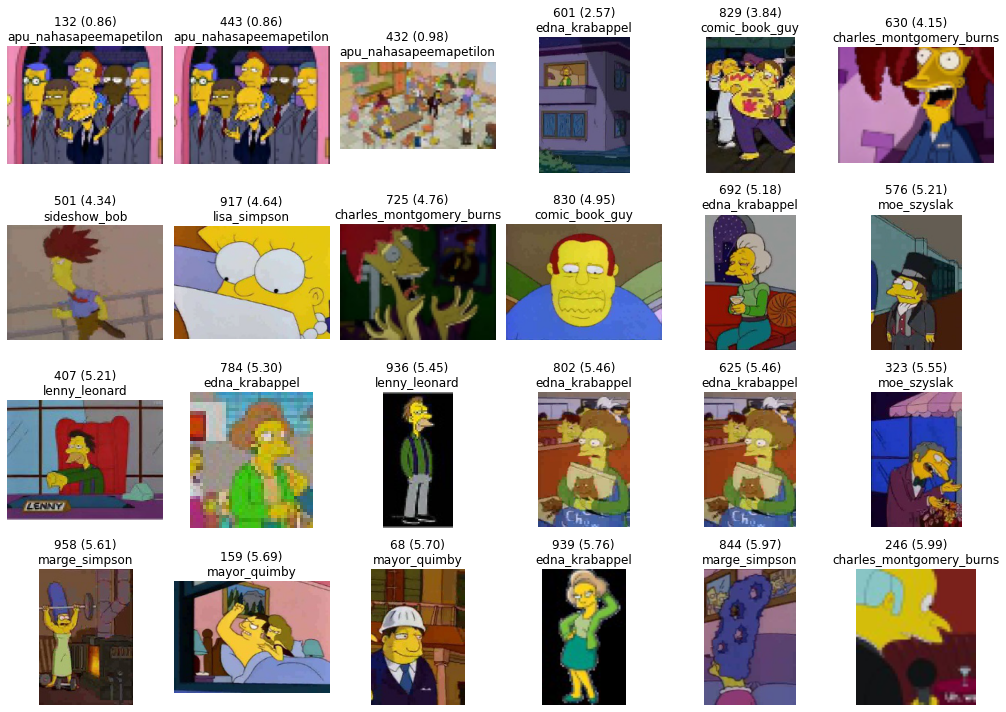

In [214]:
fig, axes = plt.subplots(4, 6, figsize=(14,10))
for i, ax in zip(sorted_max_prob_indices, axes.flat):
    im = Image.open(test_dataset.files[i])
    ax.set_title(f'{i} ({np.max(Y_prob_test[i]):.2f})\n{labels[Y_pred_test[i]]}')
    ax.imshow(im); ax.axis('off')
plt.tight_layout()

In [223]:
submission = pd.DataFrame()
submission['Id'] = [path.name for path in test_dataset.files]
submission['Expected'] = [labels[i] for i in Y_pred_test]

submission.loc[132,'Expected'] = 'charles_montgomery_burns'
submission.loc[443,'Expected'] = 'charles_montgomery_burns'
submission.loc[630,'Expected'] = 'sideshow_bob'
submission.loc[725,'Expected'] = 'sideshow_bob'

submission.to_csv('sub.csv', index=False)
submission[:10]

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [ ]:
pd.options.display.max_rows = 42
pd.options.display.max_columns = 42

th_style = {'selector':'th','props':[('font-size','7pt')]}
td_style = {'selector':'td','props':[('font-size','7pt')]}
color_zeros = lambda v: f"color: {'black' if v else 'gray'}"

df = pd.crosstab(
    pd.Series(Y_true_val, name='true'), 
    pd.Series(Y_pred_val, name='pred')
)

df = (df.style
      .applymap(color_zeros)
      .set_table_styles([th_style, td_style]))

display(df)

In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
dev = torch.device('cpu')
path = 'efficientnet_b0.pt'
state = torch.load(path, map_location=dev)
model = EfficientNet.from_name('efficientnet-b0', num_classes=42).eval()
model.load_state_dict(state)
model(torch.rand(1, 3, 224, 224))

In [ ]:
x = torch.rand(1, 3, 224, 224)
model.set_swish(memory_efficient=False)
torch.onnx.export(model, (x,), 'efficientnet-b0.onnx', input_names=('x',))

In [ ]:
import numpy as np
import onnxruntime
onnx_model = onnxruntime.InferenceSession('efficientnet-b0.onnx')
x = np.random.randn(1, 3, 224, 224).astype(np.float32)
onnx_model.run(None, {'x': x})